## Toxic: Word2Vec

In [1]:
import time

import numpy as np
import tensorflow as tf
import pandas as pd

import utils

In [2]:
import pandas as pd
df = pd.read_pickle('../data/toxictrain.pkl')
df = df[df['rating']>0]
documents = [''.join(r) for r in df.comment_text]
text = ''.join(documents)

In [3]:
import re

text = re.sub('[^A-Za-z0-9 ]+', '',text)

In [4]:
words = utils.preprocess(text)
print(words[:30])

['i', 'hope', 'your', 'retarded', 'kids', 'get', 'anal', 'raped', 'and', 'murdered', 'for', 'having', 'such', 'a', 'fag', 'as', 'a', 'father', 'im', 'gonna', 'fuck', 'your', 'fat', 'wife', 'and', 'her', 'over', 'the', 'bridge', 'consider']


In [5]:
print("Total words: {}".format(len(words)))
print("Unique words: {}".format(len(set(words))))

Total words: 753193
Unique words: 6687


In [6]:
vocab_to_int, int_to_vocab = utils.create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

In [7]:
from collections import Counter
import random

threshold = 1e-5
word_counts = Counter(int_words)
total_count = len(int_words)
freqs = {word: count/total_count for word, count in word_counts.items()}
p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}
train_words = [word for word in int_words if random.random() < (1 - p_drop[word])]

In [8]:
def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    
    R = np.random.randint(1, window_size+1)
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    target_words = set(words[start:idx] + words[idx+1:stop+1])
    
    return list(target_words)

In [9]:
def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y
    

In [10]:
train_graph = tf.Graph()
with train_graph.as_default():
    inputs = tf.placeholder(tf.int32, [None], name='inputs')
    labels = tf.placeholder(tf.int32, [None, None], name='labels')

In [11]:
n_vocab = len(int_to_vocab)
n_embedding = 200 # Number of embedding features 
with train_graph.as_default():
    embedding = tf.Variable(tf.random_uniform((n_vocab, n_embedding), -1, 1))
    embed = tf.nn.embedding_lookup(embedding, inputs)

In [12]:
# Number of negative labels to sample
n_sampled = 100
with train_graph.as_default():
    softmax_w = tf.Variable(tf.truncated_normal((n_vocab, n_embedding), stddev=0.1))
    softmax_b = tf.Variable(tf.zeros(n_vocab))
    
    # Calculate the loss using negative sampling
    loss = tf.nn.sampled_softmax_loss(softmax_w, softmax_b, 
                                      labels, embed,
                                      n_sampled, n_vocab)
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

In [13]:
with train_graph.as_default():
    ## From Thushan Ganegedara's implementation
    valid_size = 16 # Random set of words to evaluate similarity on.
    valid_window = 100
    # pick 8 samples from (0,100) and (1000,1100) each ranges. lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, 
                               random.sample(range(1000,1000+valid_window), valid_size//2))

    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))
    normalized_embedding = embedding / norm
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

In [14]:
# If the checkpoints directory doesn't exist:
# !mkdir checkpoints

In [15]:
epochs = 500
batch_size = 1000
window_size = 10

with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())

    for e in range(1, epochs+1):
        batches = get_batches(train_words, batch_size, window_size)
        start = time.time()
        for x, y in batches:
            
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % 100 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
            
            if iteration % 1000 == 0:
                # note that this is expensive (~20% slowdown if computed every 500 steps)
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = int_to_vocab[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = int_to_vocab[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
            
            iteration += 1
    save_path = saver.save(sess, "../data/checkpoints/w2v_3.ckpt")
    embed_mat = sess.run(normalized_embedding)

Epoch 1/500 Iteration: 100 Avg. Training loss: 5.0479 0.0677 sec/batch
Epoch 2/500 Iteration: 200 Avg. Training loss: 4.9490 0.0566 sec/batch
Epoch 3/500 Iteration: 300 Avg. Training loss: 4.8468 0.0464 sec/batch
Epoch 4/500 Iteration: 400 Avg. Training loss: 4.7474 0.0358 sec/batch
Epoch 5/500 Iteration: 500 Avg. Training loss: 4.6620 0.0257 sec/batch
Epoch 6/500 Iteration: 600 Avg. Training loss: 4.5784 0.0154 sec/batch
Epoch 7/500 Iteration: 700 Avg. Training loss: 4.5012 0.0057 sec/batch
Epoch 7/500 Iteration: 800 Avg. Training loss: 4.4031 0.0689 sec/batch
Epoch 8/500 Iteration: 900 Avg. Training loss: 4.3212 0.0636 sec/batch
Epoch 9/500 Iteration: 1000 Avg. Training loss: 4.2295 0.0552 sec/batch
Nearest to just: how, rag, prophet, failed, envious, warn, spite, goodness,
Nearest to about: pursue, paedophile, youd, fame, pronounce, links, adminbad, hoe,
Nearest to yourself: shitface, cowards, fuck, brain, studio, original, formats, theorist,
Nearest to hate: city, destroying, folks

Epoch 36/500 Iteration: 4100 Avg. Training loss: 3.4718 0.0499 sec/batch
Epoch 37/500 Iteration: 4200 Avg. Training loss: 3.4947 0.0395 sec/batch
Epoch 38/500 Iteration: 4300 Avg. Training loss: 3.4776 0.0291 sec/batch
Epoch 39/500 Iteration: 4400 Avg. Training loss: 3.4616 0.0188 sec/batch
Epoch 40/500 Iteration: 4500 Avg. Training loss: 3.4532 0.0098 sec/batch
Epoch 40/500 Iteration: 4600 Avg. Training loss: 3.5180 0.0702 sec/batch
Epoch 41/500 Iteration: 4700 Avg. Training loss: 3.4260 0.0675 sec/batch
Epoch 42/500 Iteration: 4800 Avg. Training loss: 3.4158 0.0569 sec/batch
Epoch 43/500 Iteration: 4900 Avg. Training loss: 3.3972 0.0463 sec/batch
Epoch 44/500 Iteration: 5000 Avg. Training loss: 3.4064 0.0357 sec/batch
Nearest to just: mewhy, envious, hence, warn, spite, addiction, english, bring,
Nearest to about: pursue, fame, adminbad, boring, paedophile, links, hoe, ballz,
Nearest to yourself: shitface, newcomer, theorist, fuck, brain, cowards, satisfy, individual,
Nearest to hate

Epoch 71/500 Iteration: 8100 Avg. Training loss: 3.1495 0.0349 sec/batch
Epoch 72/500 Iteration: 8200 Avg. Training loss: 3.1393 0.0228 sec/batch
Epoch 73/500 Iteration: 8300 Avg. Training loss: 3.1490 0.0126 sec/batch
Epoch 74/500 Iteration: 8400 Avg. Training loss: 3.2037 0.0030 sec/batch
Epoch 74/500 Iteration: 8500 Avg. Training loss: 3.1709 0.0682 sec/batch
Epoch 75/500 Iteration: 8600 Avg. Training loss: 3.1340 0.0603 sec/batch
Epoch 76/500 Iteration: 8700 Avg. Training loss: 3.1068 0.0505 sec/batch
Epoch 77/500 Iteration: 8800 Avg. Training loss: 3.1242 0.0395 sec/batch
Epoch 78/500 Iteration: 8900 Avg. Training loss: 3.1196 0.0289 sec/batch
Epoch 79/500 Iteration: 9000 Avg. Training loss: 3.1114 0.0189 sec/batch
Nearest to just: mewhy, arrest, addiction, additions, bring, hence, warn, sickness,
Nearest to about: boring, qualified, killers, withdraw, fame, pursue, public, claiming,
Nearest to yourself: shitface, newcomer, persistant, theorist, fuck, multiple, satisfy, brain,
Nea

Epoch 106/500 Iteration: 12100 Avg. Training loss: 2.9770 0.0156 sec/batch
Epoch 107/500 Iteration: 12200 Avg. Training loss: 3.0090 0.0067 sec/batch
Epoch 107/500 Iteration: 12300 Avg. Training loss: 3.0310 0.0741 sec/batch
Epoch 108/500 Iteration: 12400 Avg. Training loss: 2.9881 0.0645 sec/batch
Epoch 109/500 Iteration: 12500 Avg. Training loss: 2.9636 0.0532 sec/batch
Epoch 110/500 Iteration: 12600 Avg. Training loss: 2.9764 0.0428 sec/batch
Epoch 111/500 Iteration: 12700 Avg. Training loss: 2.9744 0.0329 sec/batch
Epoch 112/500 Iteration: 12800 Avg. Training loss: 2.9585 0.0240 sec/batch
Epoch 113/500 Iteration: 12900 Avg. Training loss: 2.9819 0.0120 sec/batch
Epoch 114/500 Iteration: 13000 Avg. Training loss: 3.0376 0.0031 sec/batch
Nearest to just: liking, arrest, additions, addiction, mewhy, backed, yes, sickness,
Nearest to about: boring, qualified, claiming, killers, public, withdraw, recent, pursue,
Nearest to yourself: shitface, persistant, newcomer, established, multiple,

Epoch 140/500 Iteration: 16100 Avg. Training loss: 2.9732 0.0691 sec/batch
Epoch 141/500 Iteration: 16200 Avg. Training loss: 2.8958 0.0675 sec/batch
Epoch 142/500 Iteration: 16300 Avg. Training loss: 2.8969 0.0572 sec/batch
Epoch 143/500 Iteration: 16400 Avg. Training loss: 2.8881 0.0473 sec/batch
Epoch 144/500 Iteration: 16500 Avg. Training loss: 2.8715 0.0360 sec/batch
Epoch 145/500 Iteration: 16600 Avg. Training loss: 2.8939 0.0258 sec/batch
Epoch 146/500 Iteration: 16700 Avg. Training loss: 2.8848 0.0155 sec/batch
Epoch 147/500 Iteration: 16800 Avg. Training loss: 2.9080 0.0058 sec/batch
Epoch 147/500 Iteration: 16900 Avg. Training loss: 2.9365 0.0681 sec/batch
Epoch 148/500 Iteration: 17000 Avg. Training loss: 2.8587 0.0635 sec/batch
Nearest to just: liking, additions, arrest, assholefuck, backed, knows, behalf, advise,
Nearest to about: boring, qualified, killers, dosent, public, claiming, withdraw, icon,
Nearest to yourself: persistant, shitface, established, newcomer, kid, ind

Epoch 175/500 Iteration: 20100 Avg. Training loss: 2.8273 0.0604 sec/batch
Epoch 176/500 Iteration: 20200 Avg. Training loss: 2.8129 0.0498 sec/batch
Epoch 177/500 Iteration: 20300 Avg. Training loss: 2.8449 0.0394 sec/batch
Epoch 178/500 Iteration: 20400 Avg. Training loss: 2.8291 0.0294 sec/batch
Epoch 179/500 Iteration: 20500 Avg. Training loss: 2.8291 0.0188 sec/batch
Epoch 180/500 Iteration: 20600 Avg. Training loss: 2.8223 0.0089 sec/batch
Epoch 180/500 Iteration: 20700 Avg. Training loss: 2.8939 0.0684 sec/batch
Epoch 181/500 Iteration: 20800 Avg. Training loss: 2.8269 0.0675 sec/batch
Epoch 182/500 Iteration: 20900 Avg. Training loss: 2.8127 0.0571 sec/batch
Epoch 183/500 Iteration: 21000 Avg. Training loss: 2.8152 0.0522 sec/batch
Nearest to just: liking, arrest, additions, behalf, assholefuck, backed, rude, knows,
Nearest to about: boring, killers, qualified, icon, rant, withdraw, eric, claiming,
Nearest to yourself: persistant, established, kid, shitface, sucksfrozen, newcom

Epoch 210/500 Iteration: 24100 Avg. Training loss: 2.7790 0.0429 sec/batch
Epoch 211/500 Iteration: 24200 Avg. Training loss: 2.7951 0.0326 sec/batch
Epoch 212/500 Iteration: 24300 Avg. Training loss: 2.7790 0.0222 sec/batch
Epoch 213/500 Iteration: 24400 Avg. Training loss: 2.7800 0.0122 sec/batch
Epoch 214/500 Iteration: 24500 Avg. Training loss: 2.8126 0.0030 sec/batch
Epoch 214/500 Iteration: 24600 Avg. Training loss: 2.7846 0.0680 sec/batch
Epoch 215/500 Iteration: 24700 Avg. Training loss: 2.7689 0.0616 sec/batch
Epoch 216/500 Iteration: 24800 Avg. Training loss: 2.7607 0.0538 sec/batch
Epoch 217/500 Iteration: 24900 Avg. Training loss: 2.7789 0.0395 sec/batch
Epoch 218/500 Iteration: 25000 Avg. Training loss: 2.7810 0.0289 sec/batch
Nearest to just: liking, arrest, additions, behalf, backed, motive, minor, assholefuck,
Nearest to about: boring, qualified, killers, eric, icon, rant, public, withdraw,
Nearest to yourself: persistant, established, kid, minoritiesi, shitface, sucksf

Epoch 245/500 Iteration: 28100 Avg. Training loss: 2.7550 0.0256 sec/batch
Epoch 246/500 Iteration: 28200 Avg. Training loss: 2.7372 0.0153 sec/batch
Epoch 247/500 Iteration: 28300 Avg. Training loss: 2.7834 0.0058 sec/batch
Epoch 247/500 Iteration: 28400 Avg. Training loss: 2.7929 0.0686 sec/batch
Epoch 248/500 Iteration: 28500 Avg. Training loss: 2.7335 0.0638 sec/batch
Epoch 249/500 Iteration: 28600 Avg. Training loss: 2.7538 0.0537 sec/batch
Epoch 250/500 Iteration: 28700 Avg. Training loss: 2.7390 0.0427 sec/batch
Epoch 251/500 Iteration: 28800 Avg. Training loss: 2.7398 0.0324 sec/batch
Epoch 252/500 Iteration: 28900 Avg. Training loss: 2.7406 0.0223 sec/batch
Epoch 253/500 Iteration: 29000 Avg. Training loss: 2.7705 0.0119 sec/batch
Nearest to just: liking, arrest, additions, minor, assholefuck, cracker, motive, knows,
Nearest to about: boring, qualified, killers, dosent, rant, hunt, states, icon,
Nearest to yourself: established, kid, persistant, minoritiesi, individual, thick,

Epoch 280/500 Iteration: 32100 Avg. Training loss: 2.7393 0.0089 sec/batch
Epoch 280/500 Iteration: 32200 Avg. Training loss: 2.7859 0.0689 sec/batch
Epoch 281/500 Iteration: 32300 Avg. Training loss: 2.7090 0.0670 sec/batch
Epoch 282/500 Iteration: 32400 Avg. Training loss: 2.7126 0.0581 sec/batch
Epoch 283/500 Iteration: 32500 Avg. Training loss: 2.7002 0.0472 sec/batch
Epoch 284/500 Iteration: 32600 Avg. Training loss: 2.7105 0.0360 sec/batch
Epoch 285/500 Iteration: 32700 Avg. Training loss: 2.7138 0.0256 sec/batch
Epoch 286/500 Iteration: 32800 Avg. Training loss: 2.7126 0.0157 sec/batch
Epoch 287/500 Iteration: 32900 Avg. Training loss: 2.7469 0.0060 sec/batch
Epoch 287/500 Iteration: 33000 Avg. Training loss: 2.7717 0.0682 sec/batch
Nearest to just: liking, arrest, new, assholefuck, motive, minor, u, cracker,
Nearest to about: qualified, boring, states, hunt, killers, dosent, icon, withdraw,
Nearest to yourself: established, kid, minoritiesi, persistant, objections, thick, teena

Epoch 314/500 Iteration: 36100 Avg. Training loss: 2.7259 0.0683 sec/batch
Epoch 315/500 Iteration: 36200 Avg. Training loss: 2.6983 0.0613 sec/batch
Epoch 316/500 Iteration: 36300 Avg. Training loss: 2.6808 0.0517 sec/batch
Epoch 317/500 Iteration: 36400 Avg. Training loss: 2.7067 0.0389 sec/batch
Epoch 318/500 Iteration: 36500 Avg. Training loss: 2.6879 0.0287 sec/batch
Epoch 319/500 Iteration: 36600 Avg. Training loss: 2.7011 0.0188 sec/batch
Epoch 320/500 Iteration: 36700 Avg. Training loss: 2.6843 0.0087 sec/batch
Epoch 320/500 Iteration: 36800 Avg. Training loss: 2.7578 0.0690 sec/batch
Epoch 321/500 Iteration: 36900 Avg. Training loss: 2.6881 0.0696 sec/batch
Epoch 322/500 Iteration: 37000 Avg. Training loss: 2.6961 0.0566 sec/batch
Nearest to just: liking, arrest, assholefuck, new, behalf, minor, backed, rude,
Nearest to about: qualified, boring, hunt, states, hated, killers, dosent, europeans,
Nearest to yourself: established, kid, minoritiesi, persistant, objections, thick, b

Epoch 349/500 Iteration: 40100 Avg. Training loss: 2.6629 0.0535 sec/batch
Epoch 350/500 Iteration: 40200 Avg. Training loss: 2.6713 0.0426 sec/batch
Epoch 351/500 Iteration: 40300 Avg. Training loss: 2.6807 0.0325 sec/batch
Epoch 352/500 Iteration: 40400 Avg. Training loss: 2.6674 0.0221 sec/batch
Epoch 353/500 Iteration: 40500 Avg. Training loss: 2.6895 0.0120 sec/batch
Epoch 354/500 Iteration: 40600 Avg. Training loss: 2.7120 0.0031 sec/batch
Epoch 354/500 Iteration: 40700 Avg. Training loss: 2.6929 0.0678 sec/batch
Epoch 355/500 Iteration: 40800 Avg. Training loss: 2.6813 0.0604 sec/batch
Epoch 356/500 Iteration: 40900 Avg. Training loss: 2.6626 0.0507 sec/batch
Epoch 357/500 Iteration: 41000 Avg. Training loss: 2.6866 0.0412 sec/batch
Nearest to just: liking, arrest, assholefuck, minor, motive, knows, new, cracker,
Nearest to about: boring, qualified, hated, europeans, hunt, affirmative, killers, states,
Nearest to yourself: established, kid, objections, minoritiesi, thick, teenag

Epoch 384/500 Iteration: 44100 Avg. Training loss: 2.6544 0.0360 sec/batch
Epoch 385/500 Iteration: 44200 Avg. Training loss: 2.6719 0.0256 sec/batch
Epoch 386/500 Iteration: 44300 Avg. Training loss: 2.6429 0.0155 sec/batch
Epoch 387/500 Iteration: 44400 Avg. Training loss: 2.6926 0.0059 sec/batch
Epoch 387/500 Iteration: 44500 Avg. Training loss: 2.7024 0.0683 sec/batch
Epoch 388/500 Iteration: 44600 Avg. Training loss: 2.6645 0.0638 sec/batch
Epoch 389/500 Iteration: 44700 Avg. Training loss: 2.6619 0.0538 sec/batch
Epoch 390/500 Iteration: 44800 Avg. Training loss: 2.6686 0.0430 sec/batch
Epoch 391/500 Iteration: 44900 Avg. Training loss: 2.6558 0.0326 sec/batch
Epoch 392/500 Iteration: 45000 Avg. Training loss: 2.6713 0.0230 sec/batch
Nearest to just: liking, arrest, assholefuck, new, rude, motive, administrative, backed,
Nearest to about: qualified, boring, hated, europeans, hunt, affirmative, states, killers,
Nearest to yourself: established, minoritiesi, kid, objections, pronou

Epoch 419/500 Iteration: 48100 Avg. Training loss: 2.6644 0.0191 sec/batch
Epoch 420/500 Iteration: 48200 Avg. Training loss: 2.6676 0.0089 sec/batch
Epoch 420/500 Iteration: 48300 Avg. Training loss: 2.7036 0.0692 sec/batch
Epoch 421/500 Iteration: 48400 Avg. Training loss: 2.6471 0.0673 sec/batch
Epoch 422/500 Iteration: 48500 Avg. Training loss: 2.6477 0.0585 sec/batch
Epoch 423/500 Iteration: 48600 Avg. Training loss: 2.6330 0.0465 sec/batch
Epoch 424/500 Iteration: 48700 Avg. Training loss: 2.6590 0.0360 sec/batch
Epoch 425/500 Iteration: 48800 Avg. Training loss: 2.6611 0.0255 sec/batch
Epoch 426/500 Iteration: 48900 Avg. Training loss: 2.6635 0.0153 sec/batch
Epoch 427/500 Iteration: 49000 Avg. Training loss: 2.6753 0.0058 sec/batch
Nearest to just: liking, arrest, assholefuck, new, minor, champion, motive, pole,
Nearest to about: qualified, hated, boring, affirmative, hunt, europeans, states, tandem,
Nearest to yourself: established, kid, objections, minoritiesi, pronounce, foo

Epoch 454/500 Iteration: 52100 Avg. Training loss: 2.6853 0.0030 sec/batch
Epoch 454/500 Iteration: 52200 Avg. Training loss: 2.6621 0.0682 sec/batch
Epoch 455/500 Iteration: 52300 Avg. Training loss: 2.6274 0.0605 sec/batch
Epoch 456/500 Iteration: 52400 Avg. Training loss: 2.6242 0.0499 sec/batch
Epoch 457/500 Iteration: 52500 Avg. Training loss: 2.6477 0.0391 sec/batch
Epoch 458/500 Iteration: 52600 Avg. Training loss: 2.6512 0.0307 sec/batch
Epoch 459/500 Iteration: 52700 Avg. Training loss: 2.6292 0.0189 sec/batch
Epoch 460/500 Iteration: 52800 Avg. Training loss: 2.6561 0.0088 sec/batch
Epoch 460/500 Iteration: 52900 Avg. Training loss: 2.6863 0.0688 sec/batch
Epoch 461/500 Iteration: 53000 Avg. Training loss: 2.6211 0.0676 sec/batch
Nearest to just: liking, arrest, assholefuck, pole, minor, new, motive, champion,
Nearest to about: qualified, affirmative, hated, boring, europeans, hunt, advocate, loud,
Nearest to yourself: established, kid, minoritiesi, objections, pronounce, foo

Epoch 488/500 Iteration: 56100 Avg. Training loss: 2.6251 0.0642 sec/batch
Epoch 489/500 Iteration: 56200 Avg. Training loss: 2.6101 0.0534 sec/batch
Epoch 490/500 Iteration: 56300 Avg. Training loss: 2.6496 0.0429 sec/batch
Epoch 491/500 Iteration: 56400 Avg. Training loss: 2.6387 0.0326 sec/batch
Epoch 492/500 Iteration: 56500 Avg. Training loss: 2.6030 0.0223 sec/batch
Epoch 493/500 Iteration: 56600 Avg. Training loss: 2.6323 0.0121 sec/batch
Epoch 494/500 Iteration: 56700 Avg. Training loss: 2.6724 0.0030 sec/batch
Epoch 494/500 Iteration: 56800 Avg. Training loss: 2.6513 0.0679 sec/batch
Epoch 495/500 Iteration: 56900 Avg. Training loss: 2.6302 0.0601 sec/batch
Epoch 496/500 Iteration: 57000 Avg. Training loss: 2.6135 0.0495 sec/batch
Nearest to just: liking, arrest, assholefuck, pole, minor, new, champion, administrative,
Nearest to about: qualified, affirmative, hated, europeans, boring, hunt, loud, advocate,
Nearest to yourself: established, kid, pronounce, objections, minoriti

In [16]:
with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    embed_mat = sess.run(embedding)

INFO:tensorflow:Restoring parameters from checkpoints/text8.ckpt


In [17]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [18]:
viz_words = 500
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

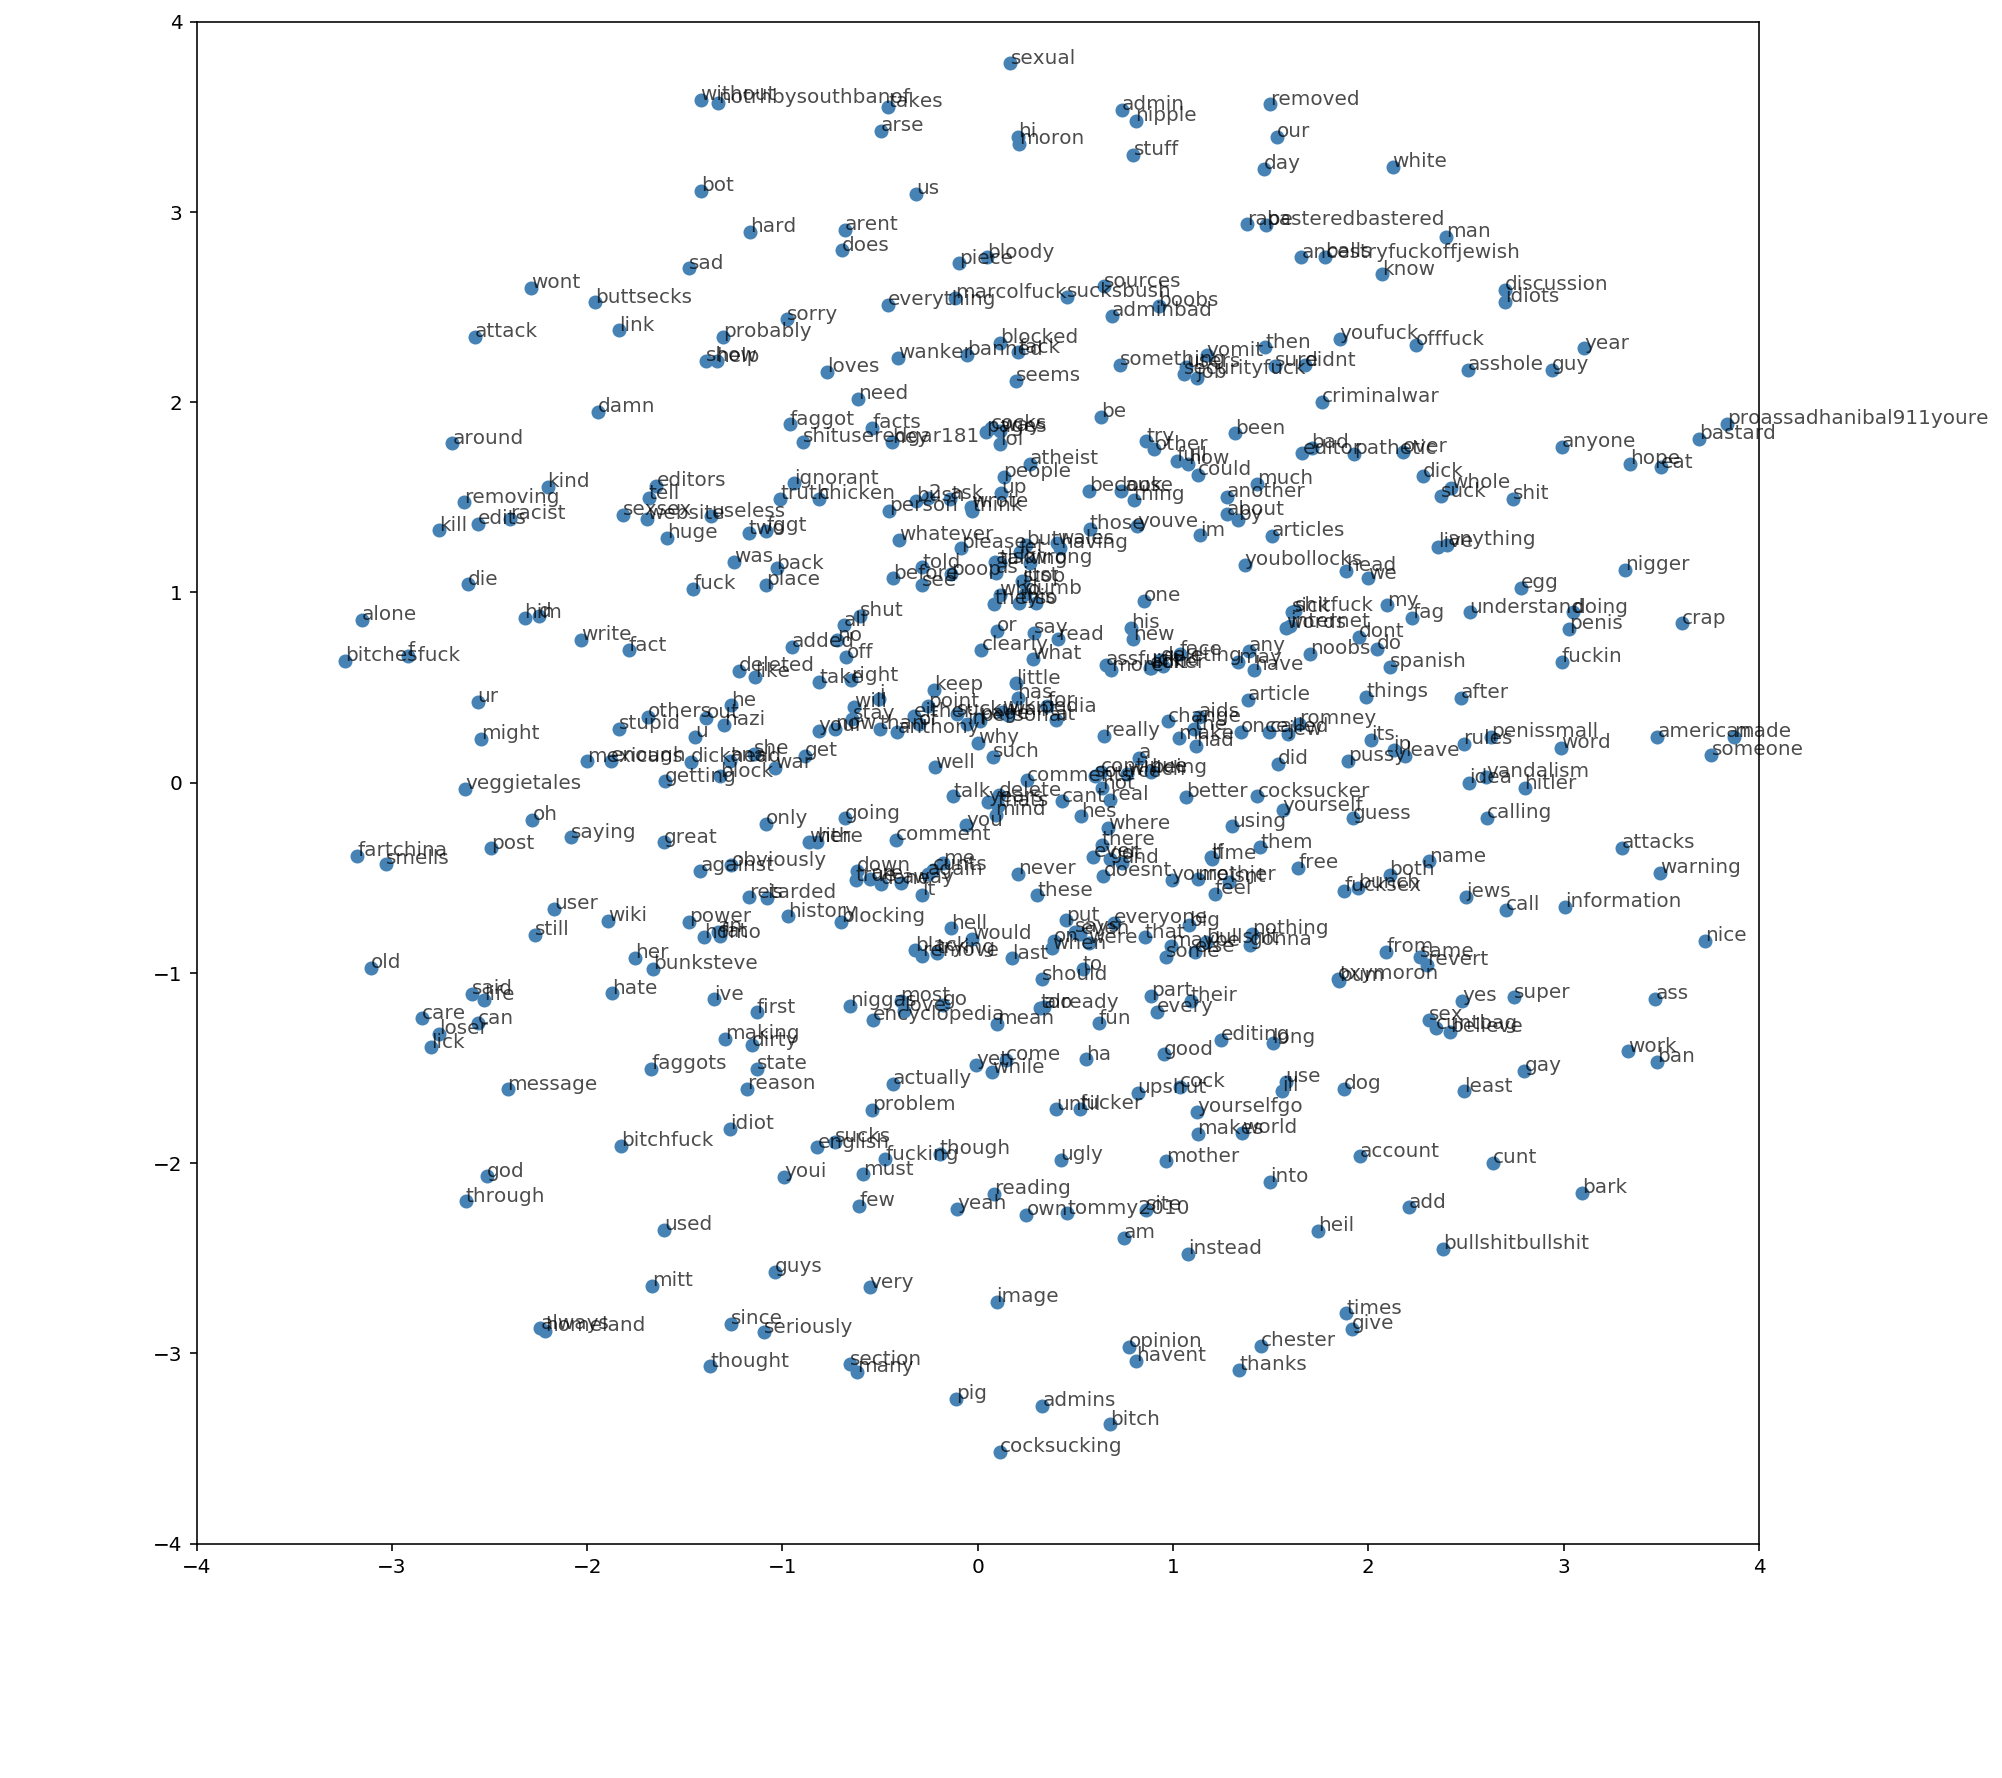

In [30]:
fig, ax = plt.subplots(figsize=(14, 14))
ax.axis([-4.0,4.0, -4.0,4.0])
ax = fig.gca()
ax.set_autoscale_on(False)

for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)